In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle
import random
import os
from torch.autograd import Variable 
from torchvision import transforms
from data_loader import VistDataset
from build_vocab import Vocabulary
from model import EncoderStory, DecoderStory
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from disp_multiple_images import show_images
%matplotlib inline

In [2]:
def transform_image(image, transform=None):
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [3]:
image_dir = './data/test'
sis_path = './data/sis/test.story-in-sequence.json'
dii_path = './data/dii/test.description-in-isolation.json'
encoder_path = './models/encoder-0.pkl'
decoder_path = './models/decoder-0.pkl'
vocab_path = './models/vocab.pkl'

img_feature_size = 1024
embed_size = 256
hidden_size = 1024
num_layers = 2

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

vist = VistDataset(image_dir, sis_path, vocab)

In [5]:
encoder = EncoderStory(img_feature_size, hidden_size, num_layers)
decoder = DecoderStory(embed_size, hidden_size, vocab)

encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

encoder.eval()
decoder.eval()

if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

In [8]:
images, targets, photo_sequences, album_ids = vist.GetItem(1300)

image_tensor = []
for image in images:
    image = transform_image(image, transform)
    image_tensor.append(image)

image_tensor = torch.stack(image_tensor).squeeze(1).unsqueeze(0)
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()

feature, (h_n, c_n) = encoder(image_tensor)
inference_results = decoder.inference(feature.squeeze(0))

sentences = []
target_sentences = []
descriptions = []

for i, result in enumerate(inference_results):
    words = []
    for word_id in result:
        word = vocab.idx2word[word_id.cpu().item()]
        words.append(word)
        if word == '<end>':
            break
            
    words.remove('<start>')
    try:
        words.remove('<end>')
    except Exception:
        pass
        
    sentences.append(' '.join(words))
    
for i, target in enumerate(targets):
    words = []
    target = target.numpy()
    for word_id in target:
        word = vocab.idx2word[word_id]
        words.append(word)
        if word == '<end>':
            break
    
    words.remove('<start>')
    try:
        words.remove('<end>')
    except Exception:
        pass
    target_sentences.append(' '.join(words))
    
print(sentences)
#print(target_sentences)

['the kids were so excited to see their favorite costume .', 'they were dressed up like a pirate .', 'she was a little scary at first .', 'then she got a picture of her .', 'she was very happy that they had a party .']


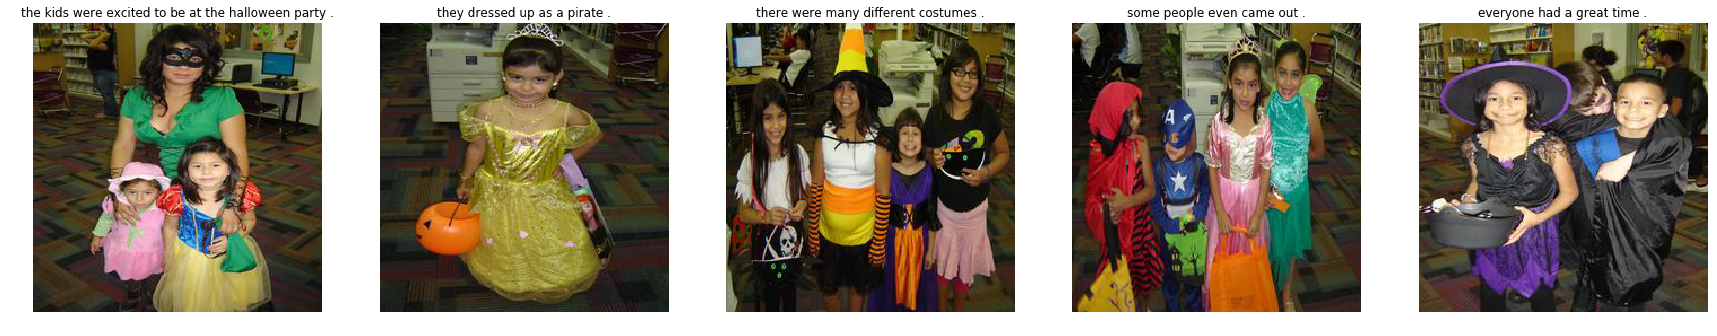

In [7]:
imgs_show = []
text_show = []
for data in zip(images, sentences):
    imgs_show.append(np.asarray(data[0]))
    text_show.append(data[1])
    
show_images(imgs_show, titles=text_show)

# METEOR Eval

## References
* https://github.com/windx0303/VIST-Challenge-NAACL-2018